## Import the relevant modules

In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mpcolors

## Load and visualize the data

In [7]:
demopath = '../data/stats/demographics.csv'
optipath = '../data/stats/painoptimization.csv'
fulloptipath = '../data/stats/painoptimization.pickle'

with open(fulloptipath, 'rb') as f:
    perfdict = pickle.load(f)

agebmisex = pd.read_csv(demopath, index_col=list(range(4)))
optidf = pd.read_csv(optipath, index_col=list(range(6)))
optidf = optidf.loc[('NewSphere', 'GroupNorm')].xs('Pain', level='Incidence')

In [8]:
agebmisex.loc[('Intersection', 'Intersection')].groupby(['PredType', 'race']).count()

KL  Age  BMI  Sex  OA_Status  \
PredType       race                                                       
FalseNegatives Asian                        1    1    1    1          1   
               Black or African American    1    1    1    1          1   
               White                       49   49   49   49         49   
FalsePositives Black or African American   13   13   13   13         13   
               Unknown or not reported      2    2    2    2          2   
               White                       25   25   25   25         25   
TrueNegatives  Black or African American   15   15   15   15         15   
               Unknown or not reported      1    1    1    1          1   
               White                      362  362  362  362        362   
TruePositives  Black or African American   30   30   30   30         30   
               Unknown or not reported      4    4    4    4          4   
               White                      103  103  103  103        103   

                                          Pain_Label  Pain_Pred  ethnicity  \
PredType       race                                                          
FalseNegatives Asian                               1          1          1   
               Black or African American           1          1          1   
               White                              49         49         49   
FalsePositives Black or African American          13         13         13   
               Unknown or not reported             2          2          2   
               White                              25         25         25   
TrueNegatives  Black or African American          15         15         15   
               Unknown or not reported             1          1          1   
               White                             362        362        362   
TruePositives  Black or African American          30         30         30   
               Unknown or not reported             4          4          4   
               White                             103        103        103   

                                          CESD  
PredType       race                             
FalseNegatives Asian                         1  
               Black or African American     1  
               White                        49  
FalsePositives Black or African American    13  
               Unknown or not reported       2  
               White                        23  
TrueNegatives  Black or African American    15  
               Unknown or not reported       1  
               White                       360  
TruePositives  Black or African American    27  
               Unknown or not reported       4  
               White                       101

In [9]:
rocmask = ['TPR', 'TNR', 'AUC', 'CV', 'Model']
oapretrain = optidf.xs(['Diagnosis'], level=['Pretraining'])[rocmask]
imgnetpretrain = optidf.xs(['ImageNet'], level=['Pretraining'])[rocmask]
randpretrain = optidf.xs(['Random'], level=['Pretraining'])[rocmask]

In [10]:
bones = ['Femur', 'Tibia', 'Patella']
fusions = ['Bone' , 'Thickness', 'T2Fusion', 'AllFusion', 'BoneCartFusion', 'CartFusion']
pretrainings = ['ImageNet', 'Random', 'Diagnosis']
optiauc = pd.DataFrame(index=range(200), columns=pd.MultiIndex.from_product([bones, fusions, pretrainings]))

for n,model in enumerate(optidf[['Model']].values):
    model = optidf[['Model']].loc[optidf[['Model']].index[n]].values[0]
    bone = optidf[['Model']].index[n][0]
    fusion = optidf[['Model']].index[n][1]
    rocmetric = 'AUC'
    auc = perfdict['NewSphere']['GroupNorm'][fusion][bone]['Pain'][model][rocmetric]
    optiauc[bone, fusion, model.split('Resnet')[0]] = auc

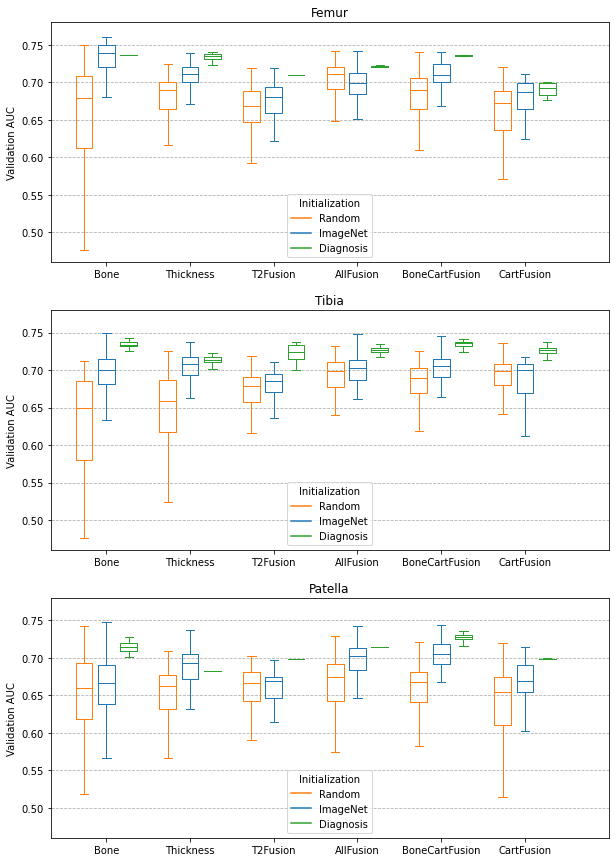

In [12]:
fig, ax = plt.subplots(3,1, figsize=(10,15));

def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)

for n,bone in enumerate(bones): 
    data_a = [optiauc[bone, fusion, pretrainings[1]].dropna().values for fusion in fusions]
    data_b = [optiauc[bone, fusion, pretrainings[0]].dropna().values for fusion in fusions]
    data_c = [optiauc[bone, fusion, pretrainings[2]].dropna().values for fusion in fusions]

    ticks = fusions

    color1 = 'tab:orange'
    color2 = 'tab:blue'
    color3 = 'tab:green'

    bp1 = ax[n].boxplot(data_a, positions=np.array(range(len(data_a)))*3.0-0.8, sym='', widths=0.6);
    bp2 = ax[n].boxplot(data_b, positions=np.array(range(len(data_b)))*3.0, sym='', widths=0.6);
    bp3 = ax[n].boxplot(data_c, positions=np.array(range(len(data_c)))*3.0+0.8, sym='', widths=0.6);
    set_box_color(bp1, color1);
    set_box_color(bp2, color2);
    set_box_color(bp3, color3);

    # draw temporary red and blue lines and use them to create a legend
    ax[n].plot([], c=color1, label=pretrainings[1]);
    ax[n].plot([], c=color2, label=pretrainings[0]);
    ax[n].plot([], c=color3, label=pretrainings[2]);
    ax[n].legend(loc='lower center', title='Initialization')

    ax[n].set_xticks(range(0, len(ticks) * 3, 3))
    ax[n].set_xticklabels(ticks)
    ax[n].set_xlim(-2, len(ticks)*3)
    ax[n].set_ylabel('Validation AUC', fontsize='medium')
    ax[n].set_ylim(0.46, 0.78)
    ax[n].grid(axis='y', linestyle='--')
    ax[n].set_title(bone, fontsize='large')

fig.savefig('../data/stats/plots/FigureS4.png', bbox_inches = 'tight', pad_inches = 0.2)